In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import re


In [ ]:
data = pd.read_csv(r"E:\Sentiment-Analysis-using-LSTM-master\twitter-data.csv",encoding='latin-1')

 ## reading the data from folder

#Considering only the necessary columns#
data = data[['SentimentText', 'Sentiment']]
data.shape    

(152939, 2)

In [3]:
# Performing data preprocessing##

data  = data[data.Sentiment != 'Netural']   ## considering only "Positive & Negative" sentiments
data ['SentimentText']  = data['SentimentText'].apply(lambda x: x.lower())
data ['SentimentText'] = data['SentimentText'].apply((lambda x: re.sub('[^a-zA-Z0-9\s]', ' ', x)))

print( data[data['Sentiment'] == 'Positive'].size)
print( data[data['Sentiment'] == 'Negative'].size)

for idx,row in data.iterrows():
  row[0] =row[0].replace('rt', ' ') ##

max_fatures = 20000
tokenizer = Tokenizer(num_words = max_fatures, split= ' ')
tokenizer.fit_on_texts(data['SentimentText'].values)
X = tokenizer.texts_to_sequences(data['SentimentText'].values)
X = pad_sequences(X)

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
C:\Users\HP\AppData\Local\Temp\ipykernel_24948\2867455428.py:5: SyntaxWarning: invalid escape sequence '\s'
  data ['SentimentText'] = data['SentimentText'].apply((lambda x: re.sub('[^a-zA-Z0-9\s]', ' ', x)))


175944
129934


C:\Users\HP\AppData\Local\Temp\ipykernel_24948\2867455428.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[0] =row[0].replace('rt', ' ') ##
C:\Users\HP\AppData\Local\Temp\ipykernel_24948\2867455428.py:11: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  row[0] =row[0].replace('rt', ' ') ##


In [4]:

#Creating layers using LSTM
embed_dim = 256    
lstm_out = 256

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

optimizer = Adam(learning_rate=0.001)  # Can tune the learning rate
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
print(model.summary())

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [5]:
Y = pd.get_dummies(data['Sentiment']).values
X_train, X_test, Y_train,Y_test = train_test_split(X,Y, test_size = 0.33, random_state= 42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(102469, 137) (102469, 2)
(50470, 137) (50470, 2)


In [6]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 3, batch_size=batch_size, verbose = 2)

Epoch 1/3
3203/3203 - 946s - 295ms/step - accuracy: 0.7566 - loss: 0.4957
Epoch 2/3
3203/3203 - 933s - 291ms/step - accuracy: 0.8092 - loss: 0.4127
Epoch 3/3
3203/3203 - 938s - 293ms/step - accuracy: 0.8374 - loss: 0.3587


In [7]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

1531/1531 - 170s - 111ms/step - accuracy: 0.7817 - loss: 0.4752
score: 0.48
acc: 0.78


In [8]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1


print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

1/1 - 0s - 391ms/step
1/1 - 0s - 65ms/step
1/1 - 0s - 57ms/step
1/1 - 0s - 57ms/step
1/1 - 0s - 58ms/step
1/1 - 0s - 53ms/step
1/1 - 0s - 56ms/step
1/1 - 0s - 59ms/step
1/1 - 0s - 85ms/step
1/1 - 0s - 58ms/step
1/1 - 0s - 54ms/step
1/1 - 0s - 51ms/step
1/1 - 0s - 52ms/step
1/1 - 0s - 53ms/step
1/1 - 0s - 63ms/step
1/1 - 0s - 54ms/step
1/1 - 0s - 53ms/step
1/1 - 0s - 53ms/step
1/1 - 0s - 53ms/step
1/1 - 0s - 54ms/step
1/1 - 0s - 55ms/step
1/1 - 0s - 57ms/step
1/1 - 0s - 56ms/step
1/1 - 0s - 55ms/step
1/1 - 0s - 64ms/step
1/1 - 0s - 55ms/step
1/1 - 0s - 56ms/step
1/1 - 0s - 56ms/step
1/1 - 0s - 56ms/step
1/1 - 0s - 54ms/step
1/1 - 0s - 57ms/step
1/1 - 0s - 52ms/step
1/1 - 0s - 59ms/step
1/1 - 0s - 52ms/step
1/1 - 0s - 63ms/step
1/1 - 0s - 53ms/step
1/1 - 0s - 52ms/step
1/1 - 0s - 55ms/step
1/1 - 0s - 52ms/step
1/1 - 0s - 56ms/step
1/1 - 0s - 54ms/step
1/1 - 0s - 52ms/step
1/1 - 0s - 51ms/step
1/1 - 0s - 53ms/step
1/1 - 0s - 55ms/step
1/1 - 0s - 51ms/step
1/1 - 0s - 58ms/step
1/1 - 0s - 5

In [12]:
##
twt  = ['i am not good']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=30, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt, batch_size=1, verbose=2)[0]
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

import pickle as pk
pk.dump(model,open('model-final.pkl','wb'))
pk.dump(tokenizer,open('scaler-final.pkl','wb'))    

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  1 77 25 30]]
1/1 - 0s - 50ms/step
1/1 - 0s - 34ms/step
negative


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Evaluate on the test set
y_pred = model.predict(X_test, batch_size=batch_size, verbose=2)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(Y_test, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='binary', pos_label=1)
recall = recall_score(y_test_classes, y_pred_classes, average='binary', pos_label=1)
f1 = f1_score(y_test_classes, y_pred_classes, average='binary', pos_label=1)
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Print the metrics
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)

1531/1531 - 131s - 86ms/step
Evaluation Metrics:
Accuracy: 78.17%
Precision: 79.96%
Recall: 82.62%
F1-Score: 81.27%
Confusion Matrix:
[[15098  5812]
 [ 4877 23183]]


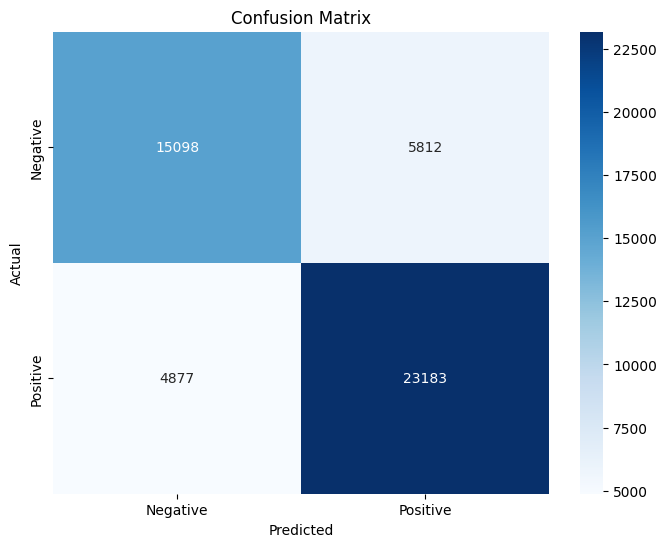

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()